In [1]:
# https://github.com/meyer-nils/torch-fem/blob/main/src/torchfem/elements.py

In [2]:
# The 'classic' 60x20 2d mbb beam, as per Ole Sigmund's 99 line code.
config = {
    "FILT_RAD": 1.5,
    "FXTR_NODE_X": range(1, 6),
    "FXTR_NODE_Y": 36,
    "LOAD_NODE_Y": 1,
    "LOAD_VALU_Y": -1,
    "NUM_ELEM_X": 5,
    "NUM_ELEM_Y": 5,
    "NUM_ITER": 94,
    "P_FAC": 3.0,
    "VOL_FRAC": 0.5,
}

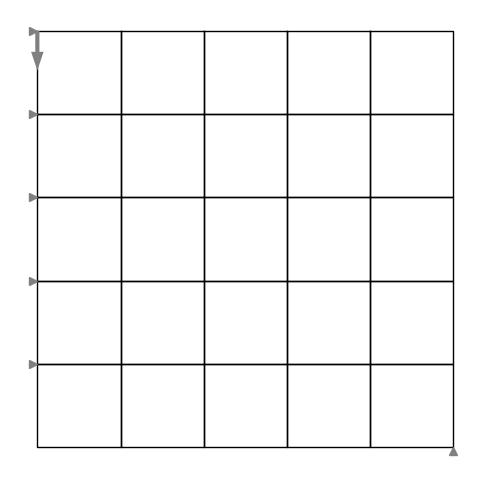

In [3]:
import torch

torch.set_default_dtype(torch.double)

from torchfem.planar import Planar
from torchfem.materials import IsotropicElasticityPlaneStress

# Material model (plane stress)
material = IsotropicElasticityPlaneStress(E=100.0, nu=0.3)

Nx = config["NUM_ELEM_X"]
Ny = config["NUM_ELEM_Y"]

# Create nodes
n1 = torch.linspace(0.0, Nx, Nx + 1)
n2 = torch.linspace(Ny, 0.0, Ny + 1)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="ij"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Create elements connecting nodes
elements = []
for j in range(Ny):
    for i in range(Nx):
        n0 = j + i * (Ny + 1)
        elements.append([n0, n0 + 1, n0 + Ny + 2, n0 + Ny + 1])
elements = torch.tensor(elements)

model = Planar(nodes, elements, material)

# Load at top
model.forces[torch.tensor(config["LOAD_NODE_Y"]) - 1, 1] = config["LOAD_VALU_Y"]

# Constrained displacement at left end
model.constraints[torch.tensor(config["FXTR_NODE_X"]) - 1, 0] = True
model.constraints[torch.tensor(config["FXTR_NODE_Y"]) - 1, 1] = True


# Plot the domain
model.plot()

In [4]:
# !pip3 install pyamg

In [5]:
# Initial, minimum, and maximum values of design variables
rho_0 = config["VOL_FRAC"] * torch.ones(len(elements), requires_grad=True)
rho_min = 0.01 * torch.ones_like(rho_0)
rho_max = torch.ones_like(rho_0)

# Volume fraction
V_0 = config["VOL_FRAC"] * Nx * Ny

# Analytical gradient of the stiffness matrix
k0 = torch.einsum("i,ijk->ijk", 1.0 / model.thickness, model.k0())

# Move limit for optimality condition algortihm
move = 0.2

# Precompute filter weights
if config["FILT_RAD"] > 0.0:
    ecenters = torch.stack([torch.mean(nodes[e], dim=0) for e in elements])
    dist = torch.cdist(ecenters, ecenters)
    H = config["FILT_RAD"] - dist
    H[dist > config["FILT_RAD"]] = 0.0

In [6]:
p = config["P_FAC"]

TORCH_SENS = False

In [7]:
model.thickness = rho_0 ** p

    # Compute solution
u_k, f_k, _, _, _ = model.solve()

In [8]:
u_k, f_k

(tensor([[ 0.0000, -1.0805],
         [ 0.0000, -0.9530],
         [ 0.0000, -0.9017],
         [ 0.0000, -0.8882],
         [ 0.0000, -0.9015],
         [ 0.2132, -0.9176],
         [-0.1148, -0.8396],
         [-0.0198, -0.8672],
         [ 0.0011, -0.8515],
         [ 0.0251, -0.8352],
         [ 0.0886, -0.8054],
         [ 0.2045, -0.7803],
         [-0.1747, -0.7146],
         [-0.0693, -0.7249],
         [-0.0066, -0.7315],
         [ 0.0512, -0.7229],
         [ 0.1397, -0.7075],
         [ 0.2492, -0.6913],
         [-0.2074, -0.5808],
         [-0.0987, -0.5865],
         [-0.0195, -0.5865],
         [ 0.0575, -0.5827],
         [ 0.1671, -0.5810],
         [ 0.3102, -0.5676],
         [-0.2193, -0.4548],
         [-0.1120, -0.4531],
         [-0.0255, -0.4425],
         [ 0.0563, -0.4207],
         [ 0.1688, -0.3996],
         [ 0.3795, -0.4030],
         [-0.2207, -0.3419],
         [-0.1142, -0.3405],
         [-0.0219, -0.3265],
         [ 0.0670, -0.2818],
         [ 0.1

In [9]:
compliance = torch.inner(f_k.ravel(), u_k.ravel())

In [10]:
compliance

tensor(1.0805, grad_fn=<ViewBackward0>)